# Algoritmo de Clasificación de Espigas No Supervisado basado en Coeficientes Wavelet, Componentes Principales y Agrupamiento tipo K-medias
### *Unsupervised Spike Classification Algorithm Based on Wavelet Coefficients, Principal Components, and K-Means Clustering*
### por Andrea Fernanda Campos Pérez y José Carlos Barreras Maldonado.
<img src="Logos.png">

# 1) Manejo de archivos NEV (Neural EVents)
### *Handling NEV (Neural Events) Files*
> Generación de archivos .dat / Generating .dat Files

This part of the code processes **NEV (Neural Events) files**, each containing the recorded neural data from a single trial of a cognitive task. It loads .MAT files with trial information, identifies and skips empty rows, and iterates through NEV files. The code extracts spike timestamps, electrode data, and waveforms, organizing them into structured .DAT files for further analysis.

In [ ]:
#--------------------------------Agregamos librerías para el manejo de archivos--------------------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy             as np
from brpylib             import brpylib_ver, NevFile
import os
import shutil
from scipy.io import loadmat

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

original_path = os.getcwd() #Definimos el directorio de trabajo original 

spath_load = str(input("Introduce el path hacia los archivos .nev \n")) #El usuario introduce el path a la carpeta con los archivos .nev
                                                                           
spath_save = str(input("Introduce el path hacia donde se guardarán los archivos .dat \n")) #El usuario introduce el path donde se guardarán los archivos .mat
                                                                                            
pos = spath_load.rfind("/") #Buscamos el último indice en el que se encuentra el elemento "/"
                              
foldername = str('%s/%s' %(spath_save, spath_load[pos+1:])) #Definimos el nombre de la carpeta en la que se guardarán los archivos .dat (que es el mismo nombre de la carpeta con los archivos .nev)

#----------------------------------------------CARGA---------------------------------------------------------------------------------------------------------------------------------------------------
#Cargamos el archivo con la psicofísica, tiempos y spike_stamps con sortinf offline (EL ARCHIVO .MAT DENTRO DE LA CARPETA NEV)
mat = loadmat(str("%s/%s.mat" %(spath_load, spath_load[pos+1:]))) #%Ejemplo de nombre del archivo: RR032152_002.mat

#Descripción de archivo mat:

                     #Es un diccionario cuyo elemento de nuestro interés es el que se encuentra asociado a la key
                     #OAresult. Este contiene un arreglo, con 5 columnas y tantas filas como ensayos. Las primeras
                     #cuatro columnas son listas de listas. La última columna es un arreglo. 

#-----------------------------------Evaluamos si hay filas vacías-----------------------------------------------------------------------------------------------------------------------------------------


#A continuación revisamos si alguna fila de la variable que acabamos de cargar (OAresult) está vacia
#Debido a que OAresult es un diccionario con listas de listas y un arreglo, aunque estas estén vacías en algún 
#renglon, su len() será mayor a cero. Por lo tanto, corroboramos si un renglón está vacío evaluando el len() de 
#la primera lista de lista de cada renglon. 

trial=0                                           #Indice que se mueve sobre la variable OAresult.
while len(mat['OAresult'][trial][0][0]) == 0:     #Bloque que permite identificar donde dejan de estar vaciós los elementos de genera.
    if len(mat['OAresult'][trial+1][0][0]) == 0:
        trial=trial+1;
    else:
        trial=trial+1;
        break                    

#En caso de que si haya filas vacias, la variable trial se convertira en el indice de la fila a partir de la cual 
#OAresult deja de tener filas vacias 

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Nclases = 0
try:
    os.mkdir(foldername)  #Creamos el directorio utilizando el nombre definido en la primera sección 
except FileExistsError:
    filt = int(input("La carpeta ya existe, quieres reemplazarla ?\n 1.Si\n 0.No"))
    if filt == 1:
        shutil.rmtree(foldername)
        os.mkdir(foldername)
    else:
        raise

directory = os.listdir(spath_load) #Obtenemos una lista con todos los archivos en la carpeta Nev
directory.sort()

N=0
flag=0                                          #Indicador para extraer información de los electrodos utilizados
Inicio_nev=0                                    #Indicador del inicio de la lectura de archivos nev
filename_sessions = str('%s/Sessions_recorded.dat' %foldername)
fileID_sessions = open(filename_sessions, 'w')  #Archivo para la carga por sessiones.

#-------------------------------------------Loop para extraer la información----------------------------------------------------------------------------------------------------------------------------------------------------------------

#Variables que serán utilizadas dentro del ciclo, pero que necesitan ser definidas afuera 

ensayos = len(mat['OAresult'])
ntrial_perclass = np.zeros(ensayos)
tmp = np.zeros(ensayos)


for ii in range(len(directory)):
    if trial>ensayos: #En la primera iteración la variable trial será el indice a partir del cual no hay
                                   #filas vacias. Sin embargo, cuando este número de indice supere la cantidad de filas
                                   #el ciclo terminará
        break
    if not directory[ii].endswith('nev'):  #El archivo no es de tipo nev y omitimos esa iteración     
        continue
    else:                                  #El archivo es del tipo nev

#En la siguiente parte del código se busca que, al final, numvalor sea igual al número que se encuentra en 
#el nombre de los archivos datafile.nev

        
        if 'datafile' in directory[ii]:
        
            numvalor = directory[ii].split('datafile')[1] #Dividimos el string y extraemos la parte que contiene el 
                                                      #número de archivo seguido de la extensión
    
            pos = numvalor.find(".")                      #Obtenemos el indice en donde está el punto que separa la extensión
        
            numvalor = numvalor[:pos]                     #Extraemos todos los números previos al punto (el número)
        
            try:
                numvalor = int(numvalor)                  #En caso de que el archivo en efecto haya sido un datafile, convertimos
            except ValueError:                            #el string en número, en caso de que no, definimos a numvalor como None
                numvalor = None
        else:
            numvalor = None
            
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------            
        
        if Inicio_nev == 0:           #Este segmento solo corre en la primera iteración en la que Inicio_nev = 0
            
            inicio_nev = 1            #Definimos las variable inicio_nev = 1
            num_valorprev = numvalor  #Se define num_valorprev como el numvalor actual
            diff = 1                  #Debido a que es el primer archivo, se establece una diferencia de 1
        
        else:
            
            diff = numvalor - num_valorprev  #En las siguientes iteraciones la diferencia será la resta entre el
                                             #num_valorprev y el numvalor
                                         
            num_valorprev = numvalor         #Se actualiza el num_valorprev
  

    #A continuación se evalua que la diferencia no sea diferente de 1, es decir, que si estabamos en el archivo 120
    #no nos hayamos pasado al 125 o al 115. Esto podria ocurrir si la fila correspondiente a ese archivo esta vacia,
    #por lo cual evaluamos esa condición. En caso de que asi sea, nos pasamos a la siguiente fila. Si no, se produce un error

    if diff != 1:
        assert len(mat['OAresult'][trial][0][0]) == 0, "Inconsistencia entre archivo genera y nev. Verificar archivos"
        trial=trial+1
    
#-----------------------------------------ABRIMOS EL ARCHIVO .NEV----------------------------------------------------------------------------------------------
    
    #Init
    chans = list(range(100)) #Definimos lista con los posibles indices de electrodos en el archivo (solo se seleccionarán aquellos que en verdad se encuentren en el archivo)
    datafile = str('%s/%s' %(spath_load,directory[ii])) #Path al archivo .nev

    #Open file and extract headers
    nev_file = NevFile(datafile)     #Convertimos al archivo .nev en un objeto Nev (clase definida en el script brpylib)

    #Extract data and separate out spike data
    spikes = nev_file.getdata(chans)['spike_events']

    #Close the nev file now that all data is out
    nev_file.close()
    
    N=N +1;                          #Incrementa el conteo del número de archivos (ensayos)
    
#--------------------------------Extraemos los datos del archivo Nev abierto------------------------------------------------------------------------------------------------------------------   

    #En el caso de Python, TimeStamps contiene los tiempos de disparo ya segmentados según el electrodo que lo detectó
    #Es decir, si en la lista con los indices de electrodos, la posición 2 la ocupa el 7, quiere decir que los tiempos
    #de disparo que se encuentran en la sublista de TimeStamps en la posición 2 son los tiempos detectados por el 
    #electrodo 7
    
    
    Spikes = spikes['TimeStamps']                 #Lista de listas, donde cada sublista contiene los tiempos de
                                                  #disparo asociados a cada electrodo
    
    
    #Solo tenemos que crear la variable con los electrodos utilizados durante la tarea una vez
    Electrodes = spikes['ChannelID']
    
    Waveform = spikes['Waveforms']
    
    #Antes de proceder, añadimos un segmento de código para que la organización de los tiempos de disparo se parezca
    #a la obtenida en matlab
    
    SpikeTimes = [item for sublist in Spikes for item in sublist] #Convertimos la lista de listas en una única lista
    SpikeTimes.sort()                                             #Ordenamos los tiempos de mayor a menor
    SpikeElectrode = np.zeros(len(SpikeTimes))                    #Creamos un arreglo con el electrodo al que corresponde 
    i = 0
    while i < len(SpikeTimes):                                    #cada tiempo de disparo
        t = SpikeTimes[i]
        for j in range(len(Electrodes)):
            if t in Spikes[j]:
                SpikeElectrode[i] = Electrodes[j]
                i+=1

    
    DimWaveform = np.shape(Waveform[0])[1]
    
    os.chdir(foldername)
    
    fileID_sessions.write( "%d,"  %mat['OAresult'][trial][0][0][0])
    
    filename = str('%s/Session%d_Times.dat' %(foldername,mat['OAresult'][trial][0][0][0]))
    fileID = open(filename,'w')
    for i in SpikeTimes:
        fileID.write('%d,' %i)
    fileID.close()

    filename = str('%s/Session%d_Electrode.dat' %(foldername, mat['OAresult'][trial][0][0][0]))
    fileID = open(filename,'w')
    for i in SpikeElectrode:
        fileID.write('%d,' %i)
    fileID.close()

    
#---Añadimos también un segmento de código para llevar a SpikeWaveform a una estructura similar a la de matlab----------------------------------------------------
    
    SpikeWaveform = np.zeros((DimWaveform,len(SpikeElectrode)))
    
    for i in range(len(Electrodes)):
        x = np.where(SpikeElectrode == Electrodes[i])[0]
        for j in range(len(Waveform[i])):
            SpikeWaveform[:,x[j]] = Waveform[i][j]

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 
            
    filename = str('%s/Session%d_Waveform.dat' %(foldername, mat['OAresult'][trial][0][0][0]))
    fileID = open(filename,'w')
    for i in range(len(SpikeWaveform)):
        for j in SpikeWaveform[i]:
            if j == len(SpikeWaveform[i])-1:
                fileID.write('%d\n' %j)
            else:
                fileID.write('%d,' %j)
    fileID.close()

    #Abrimos el archivo GeneralData.dat
    
    filename = str('%s/Session%d_GeneralData.dat' %(foldername, mat['OAresult'][trial][0][0][0])) 
    fileID = open(filename,'w')
    
    #Distintas clases de la tarea
    mat['OAresult'][trial][1][0][0]

    clase = mat['OAresult'][trial][1][0][0]
    if clase > Nclases:
        Nclases = clase
    
    #Ntrial_perclass 
    if ~(mat['OAresult'][trial][1][0][0] in tmp):
        tmp[trial] = mat['OAresult'][trial][1][0][0]
        ntrial_perclass = 1
    else:
        tmp[trial] = mat['OAresult'][trial][1][0][0]
        ntrial_perclass = sum(tmp == mat['OAresult'][trial][1][0][0])
       
    
    ntrial    = mat['OAresult'][trial][0][0][0]  #Número de ensayo 
    stim1_frec= mat['OAresult'][trial][3][0][0]  #Frecuencia del estímulo 1
    stim2_frec= mat['OAresult'][trial][3][0][3]  #Frecuencia del estímulo 2
    stim1_tact= mat['OAresult'][trial][3][0][2]  #Intensidad tactil del estímulo 1
    stim1_aud = mat['OAresult'][trial][3][0][1]  #Intensidad auditiva del estímulo 1
    stim2_tact= mat['OAresult'][trial][3][0][5]  #Intensidad tactil del estímulo 2
    stim2_aud = mat['OAresult'][trial][3][0][4]  #Intensidad auditiva del estímulo 2
    hit       = mat['OAresult'][trial][2][0][0]  #Acierto o error (1|0)
    ini_stim1 = mat['OAresult'][trial][4][0][2]  #Tiempo en el que inicia el estímulo 1
    fin_stim1 = mat['OAresult'][trial][4][0][3]  #Tiempo en el que termina el estímulo 1
    ini_stim2 = mat['OAresult'][trial][4][0][4]  #Tiempo en el que inicia el estímulo 2
    fin_stim2 = mat['OAresult'][trial][4][0][5]  #Tiempo en el que termina el estímulo 2
    fileID.write("%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d\n" %(ntrial, clase, ntrial_perclass, stim1_frec, stim2_frec, stim1_tact, stim2_tact, stim1_aud, stim2_aud, hit, ini_stim1, fin_stim1, ini_stim2, fin_stim2))
    fileID.close()
    trial+=1
    
#Guarda archivo general
SampleRes = 30000
filename = str('%s/GeneralData.dat' %foldername)
fileID = open(filename,'w');
fileID.write("%d,%d,%d,%d,%d" %(N,SampleRes,DimWaveform,len(Electrodes),Nclases))
fileID.close()
fileID_sessions.close()  #Cierra el archivo con las sesiones registradas.    


Introduce el path hacia los archivos .nev 
/home/base/Documents/Modelos3/Proyecto SS Python/RR028279_001
Introduce el path hacia donde se guardarán los archivos .dat 
/home/base/Documents/Modelos3/Proyecto SS Python/Text

Ens1.nev opened

Ens1.nev closed

Ens10.nev opened

Ens10.nev closed

Ens100.nev opened

Ens100.nev closed

Ens101.nev opened

Ens101.nev closed

Ens102.nev opened

Ens102.nev closed

Ens103.nev opened

Ens103.nev closed

Ens104.nev opened

Ens104.nev closed

Ens105.nev opened

Ens105.nev closed

Ens106.nev opened

Ens106.nev closed

Ens107.nev opened

Ens107.nev closed

Ens108.nev opened

Ens108.nev closed

Ens109.nev opened

Ens109.nev closed

Ens11.nev opened

Ens11.nev closed

Ens110.nev opened

Ens110.nev closed

Ens111.nev opened

Ens111.nev closed

Ens112.nev opened

Ens112.nev closed

Ens113.nev opened

Ens113.nev closed

Ens114.nev opened

Ens114.nev closed

Ens115.nev opened

Ens115.nev closed

Ens116.nev opened

Ens116.nev closed

Ens117.nev opened

Ens117.


Ens29.nev opened

Ens29.nev closed

Ens290.nev opened

Ens290.nev closed

Ens291.nev opened

Ens291.nev closed

Ens292.nev opened

Ens292.nev closed

Ens293.nev opened

Ens293.nev closed

Ens294.nev opened

Ens294.nev closed

Ens295.nev opened

Ens295.nev closed

Ens296.nev opened

Ens296.nev closed

Ens297.nev opened

Ens297.nev closed

Ens298.nev opened

Ens298.nev closed

Ens299.nev opened

Ens299.nev closed

Ens3.nev opened

Ens3.nev closed

Ens30.nev opened

Ens30.nev closed

Ens300.nev opened

Ens300.nev closed

Ens301.nev opened

Ens301.nev closed

Ens302.nev opened

Ens302.nev closed

Ens303.nev opened

Ens303.nev closed

Ens304.nev opened

Ens304.nev closed

Ens305.nev opened

Ens305.nev closed

Ens306.nev opened

Ens306.nev closed

Ens307.nev opened

Ens307.nev closed

Ens308.nev opened

Ens308.nev closed

Ens309.nev opened

Ens309.nev closed

Ens31.nev opened

Ens31.nev closed

Ens310.nev opened

Ens310.nev closed

Ens311.nev opened

Ens311.nev closed

Ens312.nev opened

En


Ens485.nev opened

Ens485.nev closed

Ens486.nev opened

Ens486.nev closed

Ens487.nev opened

Ens487.nev closed

Ens488.nev opened

Ens488.nev closed

Ens489.nev opened

Ens489.nev closed

Ens49.nev opened

Ens49.nev closed

Ens490.nev opened

Ens490.nev closed

Ens491.nev opened

Ens491.nev closed

Ens492.nev opened

Ens492.nev closed

Ens493.nev opened

Ens493.nev closed

Ens494.nev opened

Ens494.nev closed

Ens495.nev opened

Ens495.nev closed

Ens496.nev opened

Ens496.nev closed

Ens497.nev opened

Ens497.nev closed

Ens498.nev opened

Ens498.nev closed

Ens499.nev opened

Ens499.nev closed

Ens5.nev opened

Ens5.nev closed

Ens50.nev opened

Ens50.nev closed

Ens500.nev opened

Ens500.nev closed

Ens501.nev opened

Ens501.nev closed

Ens502.nev opened

Ens502.nev closed

Ens503.nev opened

Ens503.nev closed

Ens504.nev opened

Ens504.nev closed

Ens505.nev opened

Ens505.nev closed

Ens506.nev opened

Ens506.nev closed

Ens507.nev opened

Ens507.nev closed

Ens508.nev opened



### Carga de archivos .dat, elección de electrodo a analizar y creación del directorio para guardar imágenes.
#### *Loading .dat Files, Selecting the Electrode to Analyze, and Creating a Directory to Save Images.*

This part of the code loads **.dat files**, extracts trial and electrode data, and allows the user to select a trial range or random trials for analysis. It processes spike times, waveforms, and metadata from the selected electrode, then creates a directory to store sorting images.

In [1]:
#-----------------------Agregamos nuestro módulo de funciones compilado con Cython----------------------------#
import pyximport
pyximport.install(build_in_temp= False, inplace= True, language_level=3)
import functions

In [ ]:
#------------------------------------Agregar librerías de funciones----------------------------------------------------------------
from random import sample
from scipy.signal import savgol_filter
from scipy.interpolate import PchipInterpolator
import pywt  #pip install PyWavelets  (PARA LA INSTALACION)
from scipy import stats
from pandas import DataFrame
from seaborn import pairplot  
from mpl_toolkits.mplot3d import Axes3D
from seaborn import heatmap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.io import savemat
from sklearn.metrics import silhouette_samples

In [3]:
spath = os.getcwd()  #Agregamos la dirección actual

#--------------------------------------------Cargamos archivos .dat--------------------------------------------------------------------------------------------------------

filename = 'GeneralData.dat'                                        #Definimos el nombre del archivo que abriremos primero
path = str(input("Introduce el path hacia los archivos .dat \n"))   #Definimos el path en el que se encuentra dicho archivo


f = open(str('%s/%s') %(path,filename))     #Abrimos el archivo
A = f.read()                                #Extraemos el contenido como un único string
f.close()                                   #Cerramos el archivo
A = np.array(A.split(','))                  #Obtenemos un arreglo con los elementos del string separados por comas

N = int(A[0]);  SampleRate = int(A[1]);  DimWaveform = int(A[2]);  Nelect = int(A[3]);  Nclases = int(A[4]) #Definimos una variable para cada uno de los elementos en el arreglo

#formatsc={'r', 'b', 'g', 'k', 'c', 'y', 'm*'};

#A partir del archivo Sessions_recorded.dat creamos un vector con los números de ensayo
f = open(str("%s/Sessions_recorded.dat" %path))
trialsvec_or = f.read()
f.close()
trialsvec_or = trialsvec_or.split(',') 
trialsvec_or = np.array([int(i) for i in trialsvec_or[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio vacío

#-------------------------------------Seleccionamos ensayos a analizar-------------------------------------------------------------------------------------------

print("\nEste registro tiene %d ensayos registrados. \nPuedes elegir de dos formas las sesiones a analizar: \n 1.- rango \n 2.- aleatorio\n" %N)
typanali = int(input(":   "))

while True:
    if typanali == 1:
        ninicial = int(input("\nEnsayo inicial del rango: "))   #Extremo inicial del rango
        nfinal = int(input("\nEnsayo final del rango: "))       #Extremo terminal del rango
        trialsvector = trialsvec_or[ninicial-1:nfinal]        #Extraemos el rango de ensayos de interés                                         #Elimina auxiliar1
        break
    elif typanali == 2:
        ntrials = int(input("\nElige el número de ensayos a elegir de forma aleatoria:   "))
        trialsvector = sample(list(trialsvec_or),10)
        trialsvector.sort()
        trialsvector = np.array(trialsvector)
        break
    else:
        print("Opción invalida\n")

Nspikes = 0
del trialsvec_or

#----------------------------Carga de archivos y selección de electrodo a analizar------------------------------------------------------------------

filename = str('%s/Session%d_Electrode.dat' %(path, trialsvector[0]))
fileID = open(filename)
A = fileID.read()
fileID.close()
A = A.split(',') 
A = np.array([int(i) for i in A[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio vacío

#Desplegamos las opciones de electrodos disponibles
print("Los electrodos disponibles son: \n ")
print(np.unique(A))
print("\n")

#---------------------------Ciclo para la selección del electrodo a analizar---------------------------------------------------------------------------------------------------------------

#El electrodo seleccionado es aceptado cuando este aparece en el arreglo con los electrodos correspondientes a cada 
#tiempo de disparo por lo menos una vez

flag = True
while flag:
    nelect = int(input("\nIntroduce el número de electrodo a analizar \n"))
    if ~sum(nelect == A) > 0:                                                
        print("Debes seleccionar un electrodo adecuado \n")
    else:
        flag = False

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------        

Nspikes = Nspikes + sum(A == nelect)  #Cantidad de espigas detectadas por el electrodo seleccionado, en el ensayo en turno

#El siguiente código permite calcular la cantidad de espigas TOTALES que se detectaron por el electrodo seleccionado
#El primer ciclo recorre los distintos ensayos 
#El segundo ciclo recorre cada ensayo en busca de las espigas detectadas por el electrodo seleccionado

for nn in range(1,len(trialsvector)):
    filename = str('%s/Session%d_Electrode.dat' %(path, trialsvector[nn]))
    fileID = open(filename)
    A = fileID.read()
    fileID.close()
    A = A.split(',') 
    A = np.array([int(i) for i in A[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio vacío
    
    for ii in range(len(A)): 
        if A[ii] == nelect:
            Nspikes = Nspikes + 1         #sum(A==nelect);

#-------------------------------Nos concentramos solo en el electrodo de analisis---------------------------------------------------------------------------------------------------------        

#Definimos un conjunto de arreglos verticales que usaremos después

NspikesPerTrial = np.zeros((N,1))
Spike_Times = np.zeros((Nspikes,1))
Spike_Waveforms = np.zeros((Nspikes,DimWaveform))

Spike_Trial = np.zeros((Nspikes,1))
Spike_Class = np.zeros((Nspikes,1))
Spike_TrialPerClass = np.zeros((Nspikes,1))
Spike_Hit = np.zeros((Nspikes,1))
Spike_TimeO2 = np.zeros((Nspikes,1))         

#-------------------------------Cargamos los distintos archivos .dat en variables-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

nsp = 0
for nn in range(len(trialsvector)):
    filename = str('%s/Session%d_Electrode.dat' %(path, trialsvector[nn]))
    fileID = open(filename)
    Vec_elect = fileID.read()
    fileID.close()
    Vec_elect = Vec_elect.split(',') 
    Vec_elect = np.array([int(i) for i in Vec_elect[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio vacío
    
    filename = str('%s/Session%d_Times.dat' %(path, trialsvector[nn]))
    fileID = open(filename)
    Vec_times = fileID.read()
    fileID.close()
    Vec_times = Vec_times.split(',') 
    Vec_times = np.array([int(i) for i in Vec_times[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio vacío
    
    filename = str('%s/Session%d_Waveform.dat' %(path, trialsvector[nn]))
    fileID = open(filename)
    Vec_Waveform = fileID.read()
    fileID.close()
    Vec_Waveform = Vec_Waveform.split(',') 
    Vec_Waveform = np.array([int(i)/1000 for i in Vec_Waveform[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio vacío
    Vec_Waveform_rs = np.reshape(Vec_Waveform,(int(len(Vec_Waveform)/DimWaveform),DimWaveform),order = "F")

    filename = str('%s/Session%d_GeneralData.dat' %(path, trialsvector[nn]))
    fileID = open(filename)
    Vec_GeneralData = fileID.read()
    fileID.close()
    Vec_GeneralData = Vec_GeneralData.split(',') 
    Vec_GeneralData = np.array([int(i) for i in Vec_GeneralData[:-1]]) #Utilizamos el indice [:-1] porque el último elemento es un espacio va
        
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------       
        
#Almacenamos el contenido de los archivos que acabamos de abrir en las variables que definimos en el bloque anterior

    for ii in range(len(Vec_elect)):
        if Vec_elect[ii] == nelect:
            NspikesPerTrial[nn] = NspikesPerTrial[nn] + 1
            Spike_Times[nsp] = Vec_times[ii]
            for jj in range(DimWaveform):
                Spike_Waveforms[nsp,jj] = Vec_Waveform_rs[ii,jj]
            Spike_Trial[nsp] = trialsvector[nn]
            Spike_Class[nsp] = Vec_GeneralData[1]
            Spike_TrialPerClass[nsp] = Vec_GeneralData[2]
            Spike_Hit[nsp] = Vec_GeneralData[8]
            Spike_TimeO2[nsp] = Vec_GeneralData[9]
            nsp += 1

#------------------------------------------Directorio para guardar imagenes--------------------------------------------------------------------------------------------------------------------------------------------

img_path = str(input('\n¿En dónde quieres guardar las imagénes del sorting?\n(Lo recomendado es en la carpeta donde están los nev) '))

carp_elec = str('%s/electrodo%d' %(img_path,nelect)) 
os.mkdir(carp_elec)                                   #Se crea una carpeta con el nombre del electrodo que se está analizando
carp_img = str('%s/imagenes' %(carp_elec))
os.mkdir(carp_img)                                    #Dentro de la carpeta del electrodo, se crea otra carpeta llamada imagenes
img_path = carp_img

Introduce el path hacia los archivos .dat 
/home/base/Documents/Modelos3/Proyecto SS Python/Text/RR028221_001

Este registro tiene 160 ensayos registrados. 
Puedes elegir de dos formas las sesiones a analizar: 
 1.- rango 
 2.- aleatorio

:   1

Ensayo inicial del rango: 1

Ensayo final del rango: 160
Los electrodos disponibles son: 
 
[1 2 3 4 5 6 7]



Introduce el número de electrodo a analizar 
6

¿En dónde quieres guardar las imagénes del sorting?
(Lo recomendado es en la carpeta donde están los nev) /home/base/Documents/Modelos3/Proyecto SS Python/Text/RR028221_001


# 2) *Denoising* de los potenciales registrados por el electrodo
### *Denoising of the Potentials Recorded with the selected Electrode*

This part prompts the user to choose whether to apply **denoising** to spike waveforms. If denoising is selected, it applies a **Savitzky-Golay filter** to smooth the data. It then saves and visualizes both the **raw** and **denoised** spike waveforms as images for comparison.



¿Quiere hacer denoising?: 
 1.- SI (default) 
 2.- NO

:   1


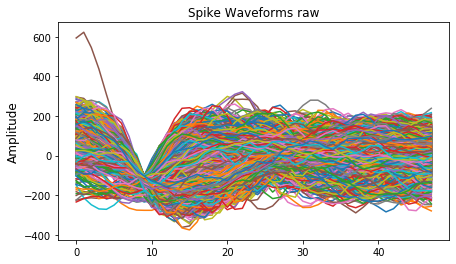

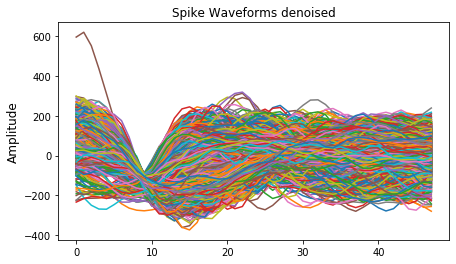

In [4]:
#-------------------------------------------Eliminación de ruido---------------------------------------------------------------------------------------------------------------------------------------------------------

print("\n\n¿Quiere hacer denoising?: \n 1.- SI (default) \n 2.- NO\n")
def_denoisy = input(':   ')

if def_denoisy != "2":
    #Eliminamos ruido
    #savgol_filter: Filter with a window length of 5 and a degree 3 polynomial. Use the defaults for all other parameters.

    Spike_Waveforms_denoised = savgol_filter(Spike_Waveforms,5,3) 

    IMG = str('%s/Spikes_raw.png' %img_path)
    plt.figure(figsize=(7,4))
    plt.plot(Spike_Waveforms.T)
    plt.title("Spike Waveforms raw")
    plt.ylabel("Amplitude", size=12)
    plt.savefig(IMG)
    
    IMG2 = str('%s/Spikes_denoised.png' %img_path)
    plt.figure(figsize=(7,4))
    plt.plot(Spike_Waveforms_denoised.T)
    plt.title("Spike Waveforms denoised")
    plt.ylabel("Amplitude", size=12)
    plt.savefig(IMG2)

else:
    Spike_Waveforms_denoised = Spike_Waveforms
    IMG = str('%s/Spikes_raw.png' %img_path)
    plt.figure(figsize=(7,4))
    plt.plot(Spike_Waveforms_denoised.T)
    plt.title("Spike Waveforms raw")
    plt.ylabel("Amplitude", size=12)
    plt.savefig(IMG)

# 3) Alineamiento de los potenciales de acción mediante interpolación de *splines* cúbicos por partes *(piecewise)*
### *Alignment of Spikes Using Piecewise Cubic Spline Interpolation*

This part **aligns spike waveforms** by interpolating them densely using **PCHIP interpolation**. It finds the **minimum value** of each waveform and shifts them accordingly. The aligned waveforms are then truncated and resampled. Finally, the aligned spike waveforms are **plotted and saved** as an image.

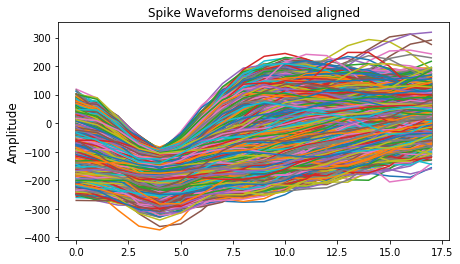

In [5]:
#-----------Alineación de las formas de onda al mismo mínimo (importante para las wavelets)--------------------------------------------------------------------------------

#Hacemos una interpolacion densa alrededor de 10 (que es el instante donde se supero el umbral)

t = np.arange(1,DimWaveform+1,1)
Factor_muestral = 80
Corte = int(Factor_muestral*4.5)
tt = np.arange(1,DimWaveform,1/Factor_muestral)  #Estaba un 35
nCorte = 4

chs= PchipInterpolator(t, Spike_Waveforms_denoised, axis= 1)  #Interpolador de SciPy
Spike_Waveforms_denoised_dense = chs(tt)

#Hallamos el instante del valor minimo interpolado
MinValue = np.min(Spike_Waveforms_denoised_dense[:, Corte:(Corte*6)], axis=1)
MinIndex= np.argmin(Spike_Waveforms_denoised_dense[:, Corte:(Corte*6)], axis=1)

MinIndex=MinIndex +Corte

#Alineamos y truncamos vector
Spike_Waveforms_denoised_aligned_dense=np.zeros((Nspikes, Corte*nCorte))

for ii in range(Nspikes):  
    Spike_Waveforms_denoised_aligned_dense[ii,:] = Spike_Waveforms_denoised_dense[ii, (MinIndex[ii]-Corte):(MinIndex[ii]+Corte*(nCorte-1))]  

cols= np.concatenate((np.sort(np.arange(Corte,1, -Factor_muestral)), np.arange(Corte+Factor_muestral, Corte*(nCorte)-1, Factor_muestral)))

Spike_Waveforms_denoised_aligned = Spike_Waveforms_denoised_aligned_dense[:, cols]

#Gráfica
IMG = str('%s/Spikes_denoised_aligned.png' %img_path)
plt.figure(figsize=(7,4))
plt.plot(Spike_Waveforms_denoised_aligned.T)
plt.title("Spike Waveforms denoised aligned")
plt.ylabel("Amplitude", size=12)
plt.savefig(IMG)

# 4) Extracción y Selección de Características mediante Coeficientes Wavelets, Análisis de Componentes Principales (PCA) y criterio Kolmogorov-Smirnov
### *Feature Extraction and Selection Using Wavelet Coefficients, Principal Component Analysis (PCA), and the Kolmogorov-Smirnov Criterion*

This part extracts and selects **spike features** using **Wavelet coefficients**, **Principal Component Analysis (PCA)**, and the **Kolmogorov-Smirnov (KS) test**. It reduces dimensionality while preserving variance, ranks features based on normality, and selects the most relevant ones. It then visualizes feature distributions with **3D scatter plots**, **heatmaps**, and **pairwise comparisons**.

### Coeficientes Wavelets / Wavelet Coefficients

In [ ]:
#-------------------------------------COEFICIENTES WAVELETS----------------------------------------------------------------------------------------------------

#Cálculo de los coeficientes Wavelet mediante una transformación discreta 1D con el wavelet Haar de nivel 4
c = pywt.wavedec(Spike_Waveforms_denoised_aligned[0,:], 'haar', level=4)
coeffs= np.concatenate((c[0], c[1], c[2], c[3], c[4]))  #De una sola onda

CoefsWL = np.zeros((Nspikes, len(coeffs))) #De todas las ondas.
for ii in range(Nspikes):
    C = pywt.wavedec(Spike_Waveforms_denoised_aligned[ii,:], 'haar', level=4)
    CoefsWL[ii,:] = np.concatenate((C[0], C[1], C[2], C[3], C[4]))
    

### Análisis de Componentes Principales (PCA) / Principal Component Analysis (PCA)

In [7]:
#--------------------------------------ANALISIS DE COMPONENTES PRINCIPALES------------------------------------------------

pca= functions.PCA(Spike_Waveforms_denoised_aligned, standardize=False)
[PCA_score, PCA_explained] = pca.Y, pca.fracs*100

aux = np.where(np.cumsum(PCA_explained)>90)[0] #Solo los  primeros PCA que lleven más del 90% de varianza 
Features = np.concatenate((CoefsWL, PCA_score[:,0:aux[0]+1]), axis=1)

### Selección de características: Test KS / Feature Selection: KS Test (Kolmogorov-Smirnov Test)

In [8]:
#-----------------------------------Test de normalidad Kolmogorov-Smirnov (KS)-----------------------------------------------------------
DimFeatures= np.shape(Features)[1]

Ptest= np.zeros(DimFeatures)
KSstat= np.zeros(DimFeatures)

for ii in range(DimFeatures):
    pd =stats.norm.fit(Features[:,ii])  #Estima parametros mu y sigma de los datos, 
                                        #ajustandolos a la distribucion normal
    mu = pd[0]
    sigma = pd[1]
    if sigma != 0:  #Esta parte se agrego por errores en algunas sesiones
        Data= (Features[:,ii]- mu)/ sigma  #Normalizacion Z-score
        KSstat[ii], Ptest[ii]= stats.kstest(Data, 'norm')  #KS test
        
    else:
        KSstat[ii], Ptest[ii]= np.zeros(1, dtype="float"), np.zeros(1, dtype='float')
        

#Ordenamos (el menos normal va ultimo)
KSstat_sort = np.sort(KSstat)
OrderIndex = np.argsort(KSstat)
Difference_KSstat_sort = np.diff(KSstat_sort) * DimFeatures / KSstat_sort[DimFeatures-1]

#Smoothing de la señal con el filtro Savitzky-Golay: 
windowSize = 7  #Tamaño de la ventana
polyOrder = 1   #Orden del polinomio

poly_fit = savgol_filter(Difference_KSstat_sort, windowSize, polyOrder)

Nfeatures = 1

while poly_fit[(DimFeatures-1)-Nfeatures] > 1:
    Nfeatures = Nfeatures + 1
    
if Nfeatures ==1:  #Forza a tener al menos 5 dimensiones
    Nfeatures= 5
    
Spike_Features = np.zeros((Nspikes, Nfeatures))

for ii in range(Nfeatures):
    index= OrderIndex[DimFeatures -1 - ii]  #index = OrderIndex(DimFeatures +1-ii);
    Spike_Features[:,ii] = Features[:, index]

### Gráficas de features / Features Visualization

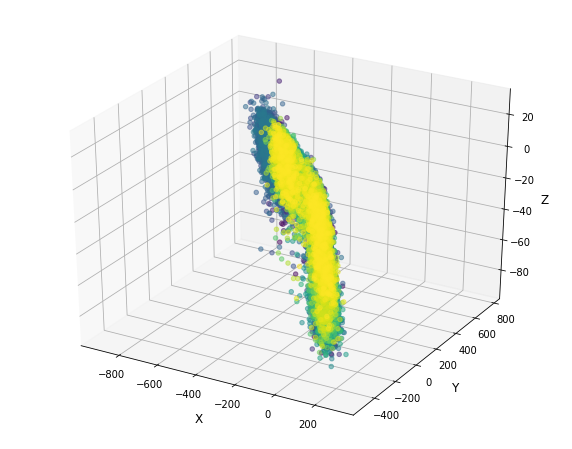

/home/base/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


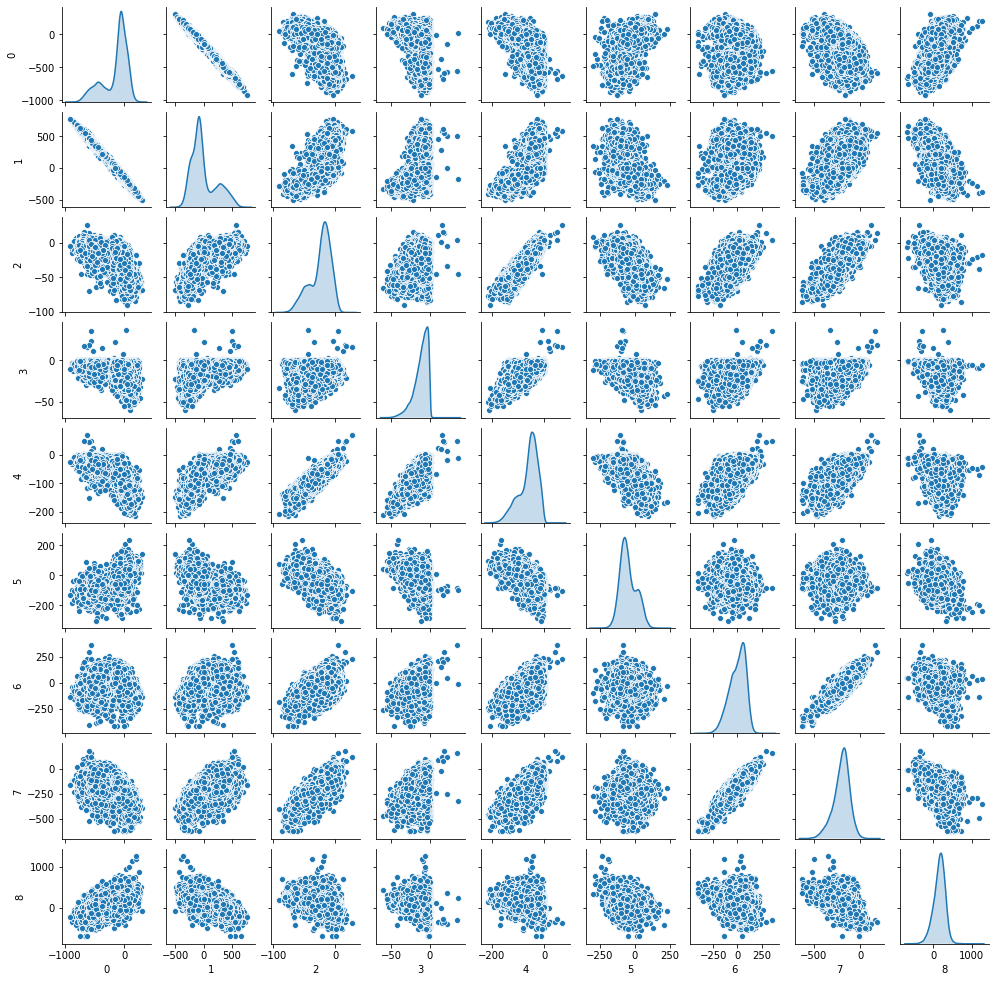

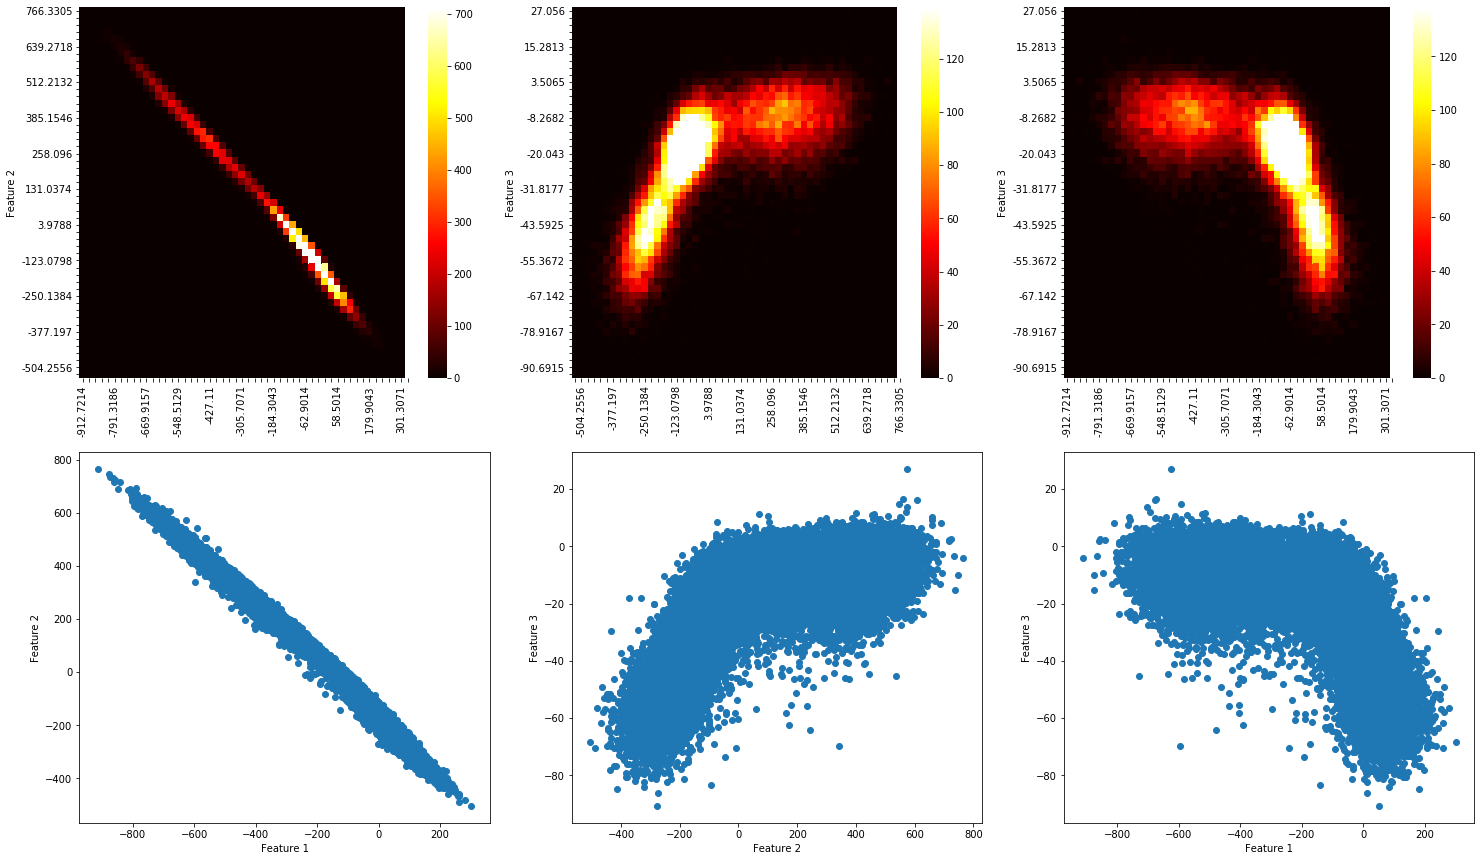

In [9]:
#Graficamos las dos dimensiones mas representativas en el tiempo de la sesion, para ver que no haya merging,
#splitting, etc
#El color indica el numero de disparo (a lo largo de la sesion)
colorvec = np.linspace(0,1,Nspikes)
nsp = np.arange(1,Nspikes+1,1)

#Scatter plot 3D
IMG = str('%s/Spike_features.png' %img_path)
fig = plt.figure(figsize=(10,8))   
ax = plt.axes(projection ="3d")     
ax.scatter3D(Spike_Features[:,0], Spike_Features[:,1], Spike_Features[:,2], c = colorvec, alpha= 0.5)
ax.set_xlabel("\nX", size=12)
ax.set_ylabel("\nY", size=12)
ax.set_zlabel("\nZ", size=12)
plt.savefig(IMG)
plt.show()

#Matriz con distribuciones de todas las features
df = DataFrame(Spike_Features)
pairplot(df, diag_kind= "kde", height=1.5)
plt.savefig(str('%s/ScatterMatrix_Features.png' %img_path))
#plt.close();


#Grafica de calor de las features + scatter 
densidad, densidad2, densidad3, Feature1, Feature2, Feature3 = functions.axis_heatmap(Spike_Features)

IMG = str('%s/Spike_features_HeatMap.png' %img_path)
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(25,15))

g1 = heatmap(densidad,  vmin = 0, vmax= np.max(densidad)*0.35, xticklabels= Feature1, yticklabels= Feature2, cmap= "hot", ax=ax1)
g1.set_ylabel('Feature 2')
g2 = heatmap(densidad2, vmin = 0, vmax= np.max(densidad2)*0.35, xticklabels= Feature2[::-1], yticklabels= Feature3, cmap= "hot", ax=ax2)
g2.set_ylabel('Feature 3')
g3 = heatmap(densidad3, vmin = 0, vmax= np.max(densidad3)*0.35, xticklabels= Feature1,       yticklabels= Feature3, cmap= "hot", ax=ax3)
g3.set_ylabel('Feature 3')

ax4.scatter(Spike_Features[:,0], Spike_Features[:,1])
ax4.set_xlabel('Feature 1')
ax4.set_ylabel('Feature 2')
ax5.scatter(Spike_Features[:,1], Spike_Features[:,2]) 
ax5.set_xlabel('Feature 2') 
ax5.set_ylabel('Feature 3')
ax6.scatter(Spike_Features[:,0], Spike_Features[:,2])
ax6.set_xlabel('Feature 1')
ax6.set_ylabel('Feature 3')
fig.savefig(IMG)
fig.show()

# 5) Agrupamiento mediante el algoritmo de K-means
### *Clustering Using the K-Means Algorithm*

This part applies **K-means clustering** to classify spike features, optimizing the number of clusters using **silhouette scores**. It allows users to **remove noise** by filtering spikes beyond a specified standard deviation. The results are visualized through **scatter plots, heatmaps, raster plots, and stability graphs**.

Por ahora el programa solo cuenta con el algoritmo de clustering K-means

Introduce el número de clusters: 3


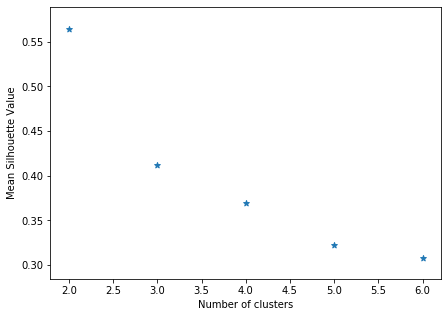

Seleccione el número de clusters: 2


/home/base/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


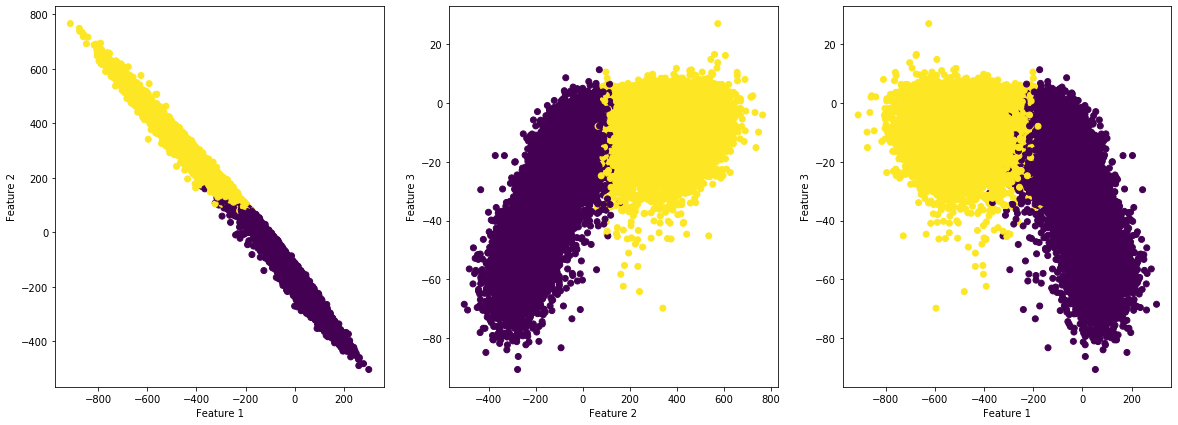

In [10]:
#-------------------------------------------Agrupamiento para la clasificación---------------------------------------------------------------------------------------

print('Por ahora el programa solo cuenta con el algoritmo de clustering K-means\n')
Ncp = int(input("Introduce el número de clusters: "))  #Número de clusters
sil_graf = np.zeros(Ncp+2)
for Nc in range(2,Ncp+4):  #Ncp  antes 10
    kmeans    = KMeans(Nc).fit(Spike_Features)
    sil_value = silhouette_score(Spike_Features,kmeans.labels_)
    sil_graf[Nc-2] = sil_value

#Gráfica de Silhoutte
IMG = str('%s/Clusters_silhouette.png' %img_path)
plt.figure(figsize=(7,5))
plt.scatter(np.arange(2,Ncp+4,1),sil_graf,marker= '*')
plt.xlabel("Number of clusters")
plt.ylabel('Mean Silhouette Value') 
plt.savefig(IMG)
plt.show()
    
#Cuántos clusters vamos a escoger
Nc = int(input('Seleccione el número de clusters: '))

if Nc != 1:
    kmeans = KMeans(Nc).fit(Spike_Features)
    kmeans_labels= kmeans.labels_.copy()
    centroides = kmeans.cluster_centers_.copy()
    sil_value = silhouette_score(Spike_Features,kmeans_labels)

    #Gráfica de pares de Features
    IMG = str('%s/Features_scatter.png' %img_path)
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7))
    ax1.scatter(Spike_Features[:,0],Spike_Features[:,1],c= kmeans_labels)
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax2.scatter(Spike_Features[:,1],Spike_Features[:,2],c= kmeans_labels)
    ax2.set_xlabel('Feature 2')
    ax2.set_ylabel('Feature 3')
    ax3.scatter(Spike_Features[:,0],Spike_Features[:,2],c= kmeans_labels)
    ax3.set_xlabel('Feature 1')
    ax3.set_ylabel('Feature 3')
    fig.savefig(IMG)
    fig.show()
    
else:
    #K means de 1 cluster
    kmeans_labels, centroides, iteraciones= functions.kmeans(Spike_Features, Nc) 
    kmeans_labels= kmeans_labels-1
    centroides = np.asarray(centroides, dtype=np.float32)
    
    #Grafica
    IMG = str('%s/Features_scatter.png' %img_path)
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7))
    ax1.scatter(Spike_Features[:,0],Spike_Features[:,1],c= kmeans_labels)
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax2.scatter(Spike_Features[:,1],Spike_Features[:,2],c= kmeans_labels)
    ax2.set_xlabel('Feature 2')
    ax2.set_ylabel('Feature 3')
    ax3.scatter(Spike_Features[:,0],Spike_Features[:,2],c= kmeans_labels)
    ax3.set_xlabel('Feature 1')
    ax3.set_ylabel('Feature 3')
    fig.savefig(IMG)
    fig.show()

### Remoción de ruido / Noise Removal

In [11]:
#-----------------------------------Remoción de valores que podrían ser ruido-----------------------------------------------------------------------------------------------------------------------------------------------------------

print("Cuando solo hay un cluster es recomendable eliminar ruido \n")
print("¿Desea remover posible ruido?: \n 1:  SI \n Otro : No \n")
rmnoise= int(input(": "))

if rmnoise == 1:
    print('\nConsidera  como ruido todos los elementos que se encuentran a más de n sigmas del centroide')
    sig = int(input("El valor de sigmas por default es 4, ¿quieres cambiarlo?  \n 1:  Si \n 0: No \n"))
    if sig == 1:
        sigmas = int(input("\nIntroduce a partir de cuántas sigmas de distancia se considera como ruido \n"))
    else:
        sigmas = 4
        
    if Nc != 1:
        centroids_new= centroides
        for Nclus in range(Nc):
            sampl= np.where(kmeans_labels == Nclus)[0]
            distances= Spike_Features[sampl, :] - centroides[Nclus, :]
            for ii in range(np.size(Spike_Features, 1)):
                th= sigmas*np.std(distances[:, ii])
                tmp= distances[:, ii]>th
                if sum(tmp)>=1:
                    kmeans_labels[sampl[tmp]]=-1        #El indice de los elementos a más de n sigmas de distancia se cambia a -1
                    centroids_new[Nclus,ii]= np.mean(Spike_Features[sampl,ii][~tmp])  #Calculamos el promedio de todos los elementos del cluster en turno (Nclus), cuya distancia al centroide es menor a n sigma (~tmp)
                    
                    
    else:
        centroids_new= centroides
        distances= Spike_Features - centroides
        for ii in range(np.size(Spike_Features,1)):
            th= sigmas*np.std(distances[:,ii])
            tmp= distances[:,ii]> th
            if sum(tmp)>=1:
                kmeans_labels[tmp]=-1        #El indice de los elementos a más de n sigmas de distancia se cambia a -1
                centroids_new[0][ii]= np.mean(Spike_Features[:,ii][~tmp]) #Calculamos el promedio de todos los elementos del cluster en turno (Nclus), cuya distancia al centroide es menor a n sigma (~tmp)

Cuando solo hay un cluster es recomendable eliminar ruido 

¿Desea remover posible ruido?: 
 1:  SI 
 Otro : No 

: 1

Considera  como ruido todos los elementos que se encuentran a más de n sigmas del centroide
El valor de sigmas por default es 4, ¿quieres cambiarlo?  
 1:  Si 
 0: No 
1

Introduce a partir de cuántas sigmas de distancia se considera como ruido 
6


### Revisión visual del Spike Sorting / Visual Review of Spike Sorting

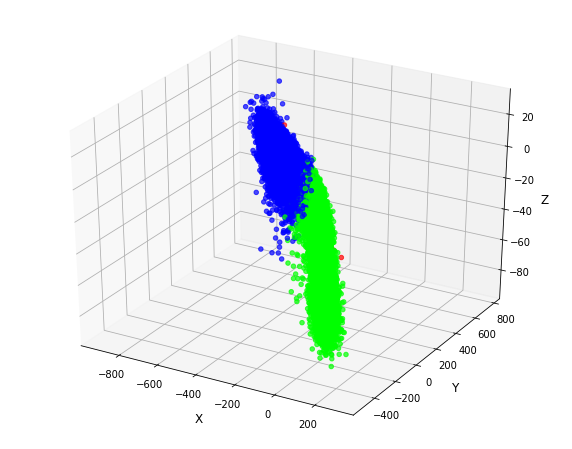

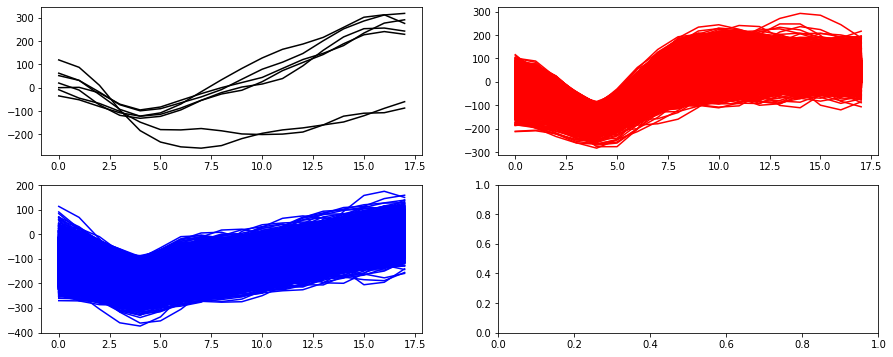

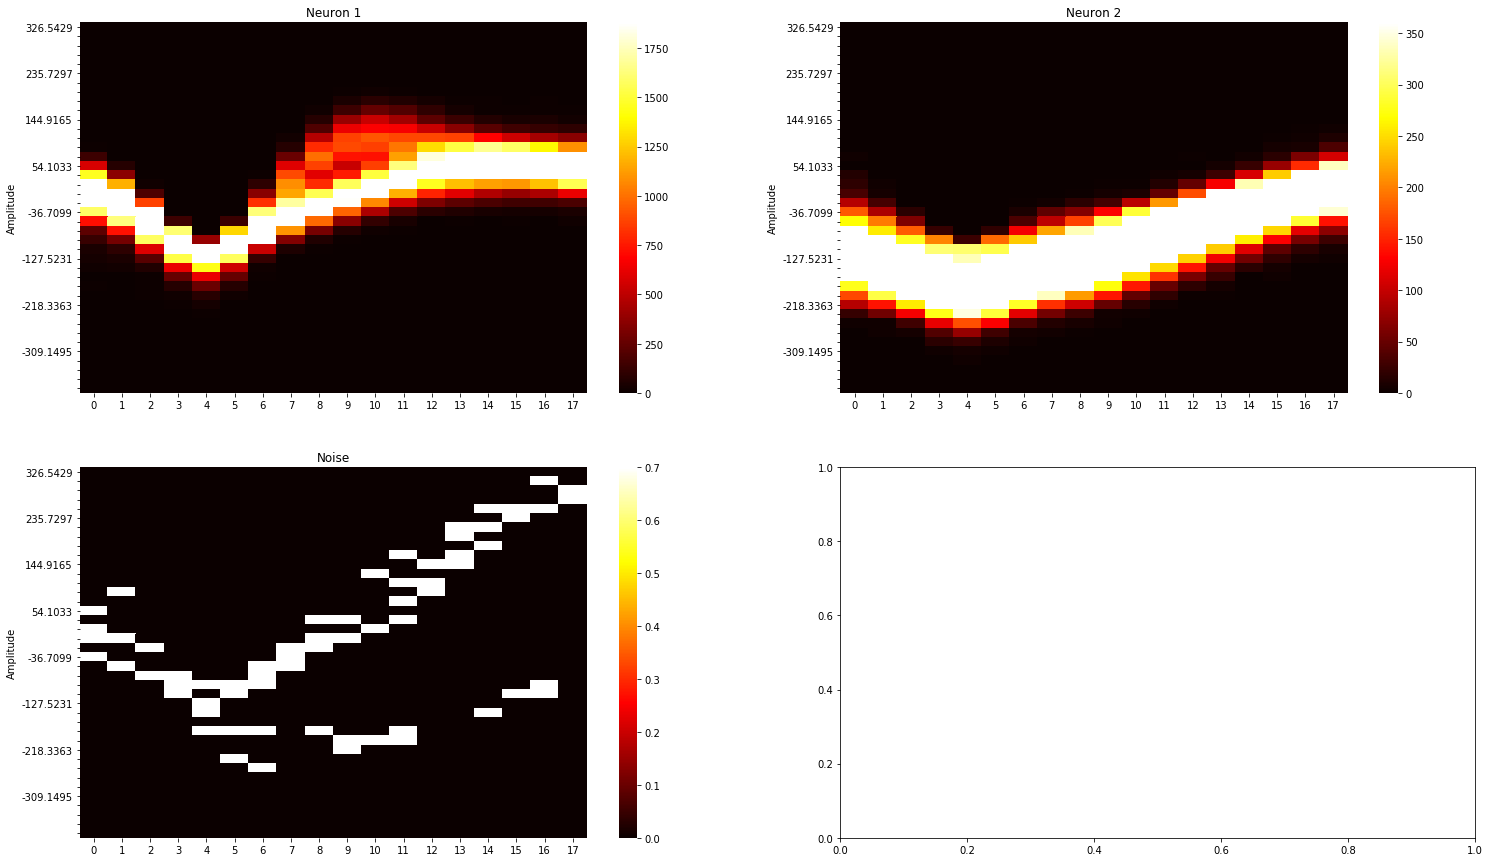

¿Quieres cambiar la fracción de la gráfica de ruido? 
1.SI
0.NO 
 0


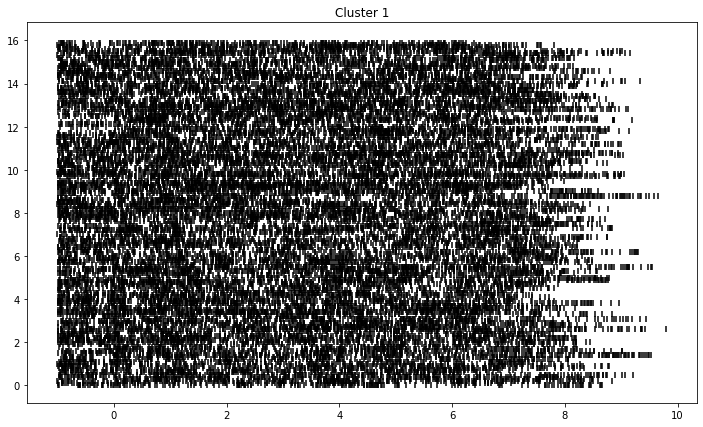

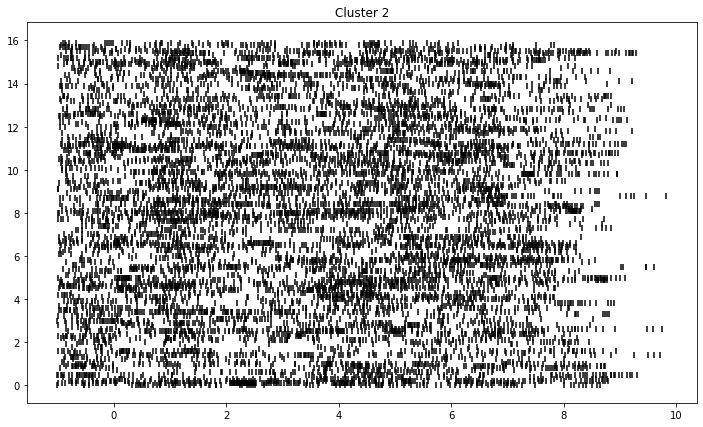

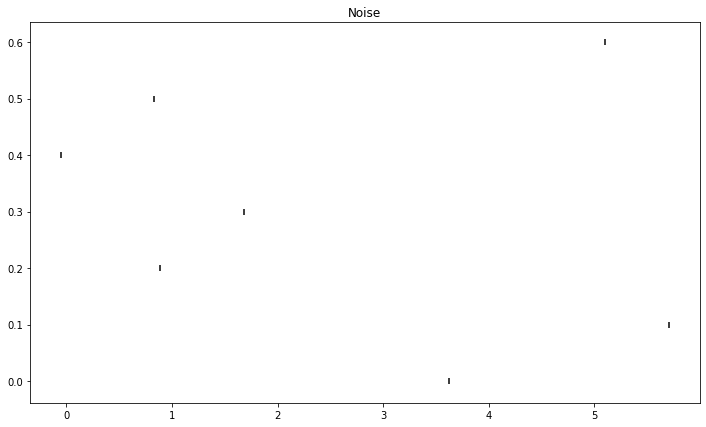

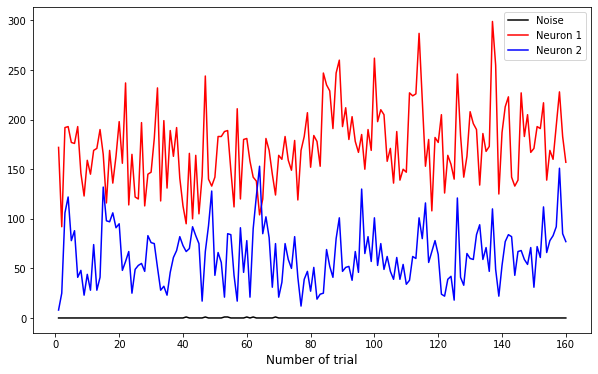

In [12]:
#Grafica scatter3D de elementos por cluster al que pertenecen
#Grafica de espigas por cluster al que pertenecen 
functions.show_classification(kmeans_labels,Spike_Features,Spike_Waveforms_denoised_aligned,[],img_path, True) 

#Grafica del mapa de calor de las formas de onda de las espigas de cada neurona clasificada
functions.spikesheat_plot(Spike_Waveforms_denoised_aligned, Nc, rmnoise, kmeans_labels, img_path, True)

#Grafico raster de la actividad de cada neurona clasificada, y si es el caso, del ruido
functions.rasterplot(Spike_Times-Spike_TimeO2*30000, Spike_Trial, kmeans_labels, img_path ,Spike_Class, save= True)

#Grafica de estabilidad, i.e., numero de espigas por ensayo por neurona
nsppertrial, labels = functions.stability_plot(kmeans_labels, Spike_Trial, img_path, True)

### Etapa de intercambio de etiquetas / Label Exchange Stage

In [13]:
#---------------------------------------Etapa de intercambio de etiquetas--------------------------------------------------------------------------------------------------------------------------------------------

cm= int(input("¿Desea intercambiar clasificaciones? :\n 1: Si \n Otro: No \n"))
if cm==1:
    if Nc != 1:
        print("\nIngrese los clasificadores a cambiar")
        ahora = int(input("Ahora: "))
        despues = int(input("Después: "))

        while True:
            auxiliar = kmeans_labels.copy()
            auxiliar[kmeans_labels ==ahora]=despues
            auxiliar[kmeans_labels ==despues]=ahora
            kmeans_labels = auxiliar
            salida= int(input("¿Desea realizar otro intercambio?\n 1:Si \n Otro: No \n"))
            if  salida==1:
                print("\nIngrese los clasificadores a cambiar")
                ahora = int(input("Ahora: "))
                despues = int(input("Después: "))
            else:
                del auxiliar,salida 
                break
    else:
        raise ValueError("No se pueden intercambiar etiquetas porque solo hay UNA neurona.\n\t\tTus datos no fueron modificados.")

¿Desea intercambiar clasificaciones? :
 1: Si 
 Otro: No 
0


# 6) Evaluación del resultado de la clasificación mediante coeficientes de correlación de Pearson y Prueba de hipótesis
### *Classification Result Evaluation Using Pearson Correlation Coefficients and Hypothesis Testing*

This part evaluates **classification results** using the **Pearson correlation coefficient** to assess relationships between spike counts across trials. Ideally, low correlations should be observed between spikes from different classified neurons. It computes a **correlation matrix**, conducts **hypothesis testing**, and provides **confidence intervals** to determine the statistical significance of neuronal activity patterns.

In [14]:
#--------------------------------Evaluación de la clasificación: Matriz de correlación ------------------------------------------------------------------------------------------------------------

R, P, RL, RU = functions.corrcoef(nsppertrial)
print("Los resultados de la correlación de Pearson entre el número de espigas por ensayo de las distintas neuronas son: \n")
print("R: Matriz de correlación \n")
print(R)
print("\nP: Prueba de hipótesis. No existe relación entre los fenómenos observados (p-value) \n")
print(P)
print("\nRL: Limite inferior para Intervalo de confianza del 95% \n");
print(RL);
print("\nRU: Limite superior para Intervalo de confianza del 95% \n");
print(RU)

Los resultados de la correlación de Pearson entre el número de espigas por ensayo de las distintas neuronas son: 

R: Matriz de correlación 

[[ 1.         -0.03628786  0.04359717]
 [-0.03628786  1.          0.13281401]
 [ 0.04359717  0.13281401  1.        ]]

P: Prueba de hipótesis. No existe relación entre los fenómenos observados (p-value) 

[[1.         0.64870622 0.58410264]
 [0.64870622 1.         0.09408497]
 [0.58410264 0.09408497 1.        ]]

RL: Limite inferior para Intervalo de confianza del 95% 

[[ 1.         -0.19037472 -0.11232137]
 [-0.19037472  1.         -0.02281489]
 [-0.11232137 -0.02281489  1.        ]]

RU: Limite superior para Intervalo de confianza del 95% 

[[1.         0.11954396 0.19742047]
 [0.11954396 1.         0.28215824]
 [0.19742047 0.28215824 1.        ]]


# 7) Guardado de los resultados 
### *Saving the Result Files*

In [15]:
#-----------------------------------------Guardado de datos de la clasificación-------------------------------------------------------------------------------------------------------------------------------------------

aux= path.rfind("/")

if typanali==1:
    savefilename=str("%s/%s_sorted_elec%d_seq_%d-%d.mat" %(carp_elec , path[aux+1:-3], nelect, ninicial, nfinal))
else:
    savefilename=str("%s/%s_sorted_elec%d_rnd_%d.mat"   %(carp_elec, path[aux+1:-3], nelect, ntrials))
       
classification = kmeans_labels
classification = np.vstack(classification + 1)  #Convertimos al vector horizontal en vertical
classification[classification==0] = -1          #Convertimos a los 0's en -1    
cl = np.unique(classification)

#Convertimos los resultados de la evaluación con correlación y pruebas de hipótesis en un arreglo lineal

corr = np.zeros((4,len(P.ravel())))
for i in range(len(corr)):
    corr[i,:] = [R, P, RL, RU][i].ravel()

if Nc == 1:    #Cuando solo hay un cluster, ni calculamos, ni guardamos los valores de silhoutte
    
    R28dat =  {'TimeStamps': Spike_Times,'Trials':Spike_Trial,'class':classification,"meta":{"cl":cl,"labels":labels},"corr":corr,"centroids":centroides}
else: 
    
    #Calculamos el valor de silhoutte para cada elemento (antes se habia calculado el valor promedio)
    silhoutte = silhouette_samples(Spike_Features,classification)
    silhoutte = np.vstack(silhoutte)
    
    R28dat =  {'TimeStamps': Spike_Times,'Trials':Spike_Trial,'class':classification,"meta":{"cl":cl,"labels":labels},"corr":corr,"centroids":centroides,"metric":silhoutte}

savemat(savefilename, R28dat)

/home/base/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
